- The covariance matrix is divided by the number of shots
- The temperature is iterated by averaging over all the previous velocities
- Use statevector_simulator for VQE and qasm_simulator for the expectations

Compared the results of $N_{shots} = 256, 512, 1024$.

$\Delta = 30$; dt = 0.2 fs; v_init = [100, -100]; init_pos = [0, 0.6]

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

Fit the potential surface

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo,gto, scf

from typing import Tuple


# qiskit
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.algorithms import MinimumEigensolverResult

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli, SparsePauliOp

# qiskit nature
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

from qiskit import IBMQ
from qiskit_nature.runtime import VQEClient
from qiskit.providers.ibmq import least_busy
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# useful??
#from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                      NumPyMinimumEigensolverFactory)
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import TwoQubitReduction

In [3]:
def get_molecular_integrals(molecule):
    '''
    Calculates the 1-electron and 2-electron integrals.
    
    Args:   
        molecule : Mole 
            Ccorresponds to the molecule.
            
    Returns:
        h1_MO : ndarray
                Tensor corresponding to the 1-electron integral in the molecular basis.
        
        h2_MO : ndarray
                Tensor corresponding to the 2-electron integral in the molecular basis.

        n_particles: Tuple[int, int]
            Number of alpha and beta electrons.
        
        num_orb : int 
            Number of orbitals.

        nuclear_repulsion_energy : float
            Nuclear repulsion energy.
    '''
    
    mf = scf.RHF(molecule).run()

    # computing the 1e and 2e AO (atomic orbitals) integrals 
    h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
    h2 = molecule.intor("int2e")
    # comment : add aosym (axis of symmetry) ???

    # transformations from AO to MO (molecular orbitals)
    h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
    h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

    #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

    nuclear_repulsion_energy=molecule.energy_nuc()
    num_particles = molecule.nelec
    num_orb = h1.shape[0]

    return h1_MO, h2_MO, num_particles, num_orb, nuclear_repulsion_energy


def get_qubit_op(coordinates):
    '''
    Calculates the Hamiltonian as the sum of Pauli operators as a function
    of the coordinates of the atoms.
    
    Args:
        coordinates : ndarray
            Array containing the positions of the atoms constituing the molecule.
        
    
    Returns:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
    '''
    
    mol = gto.M(
                atom = [['H',(coordinates[0], 0.0, 0.0)], 
                        ['H',(coordinates[1], 0.0, 0.0)]],
                basis = 'sto3g',
                charge = 0,
                spin = 0,
                symmetry = True,
                verbose = 2 # control the print level of PySCF globally
    )

    h1_MO,h2_MO,nelec,norb,ecore = get_molecular_integrals(mol)

    # Define an ElectronicEnergy instance containing the 1e and 2e integrals
    electronic_energy = ElectronicEnergy.from_raw_integrals(
            h1_MO, ao2mo.restore(1, h2_MO, norb)
        )
    electronic_energy.nuclear_repulsion_energy = ecore

    # Define an ElectronicStructureProblem
    problem = ElectronicStructureProblem(electronic_energy)

    second_q_ops = problem.second_q_ops()     # get second quantized operators
    problem.num_spatial_orbitals = norb  # define number of orbitals
    problem.num_particles = nelec        # define number of particles 
    
    problem.basis = ElectronicBasis.MO 
    
    problem.molecule=MoleculeInfo(symbols=[mol.atom_symbol(i) for i in range(mol.nbas)], 
                                  coords=mol.atom_coords())
    FC_transformer=FreezeCoreTransformer(freeze_core=True)
    problem = FC_transformer.transform(problem)
    
    # TODO we need to give info about the molecule to use FreezeCoreTransformer 
    # question : how to do it in a smart way ? at the initialization ??
    
    hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
    hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=norb)) # add Nuclear Repulsion Energy
    #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
    
    mapper = ParityMapper()  # Set Mapper
    
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian, nelec)
    #print("q_op :\n", qubit_op) # print for checking purposes
    

    return qubit_op, nelec, norb, problem, converter

def calc_ground_state(qubit_op,nelec,norb,problem,converter, shots=1024) :
    '''
    Calculates the ground state and the ground energy of the Hamiltonian.
    
    Args:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
        
    
    Returns:
        ground_state : CircuitStateFn
            Ground state of the Hamiltonian.
            
        min_eng : float
            Ground energy of the Hamiltonian.
    '''

    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = COBYLA(maxiter=500)
    
#     backend = Aer.get_backend('qasm_simulator') 
#     quantum_instance = QuantumInstance(backend,shots=shots)
#     optimizer = COBYLA(maxiter=200)

    init_state = HartreeFock(num_spatial_orbitals=norb, 
                                num_particles=nelec, 
                                qubit_converter=converter
                            )
    
    var_form = UCCSD(qubit_converter=converter,
                        num_particles=nelec,
                        num_spatial_orbitals=norb, 
                        initial_state=init_state
                        )

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    min_eng = vqe_result.eigenvalue.real
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params) 
#     vqe_ground_state = CircuitStateFn(vqe_ground)
    
    return vqe_ground, min_eng

In [4]:
distances = np.arange(0.7, 0.8, 0.001)
def calc_energy(distances): 
    vqe_energies = []
    for dist in distances:
        #get qubit operator corresponding to H(R)
        (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op([0, dist])
        #get the ground state of H(R)
        psi_0, mineng = calc_ground_state(qubit_op,num_part, num_orb, problem, converter)
        vqe_energies.append(mineng)
    return vqe_energies

In [5]:
vqe_sv_eng = calc_energy(distances)

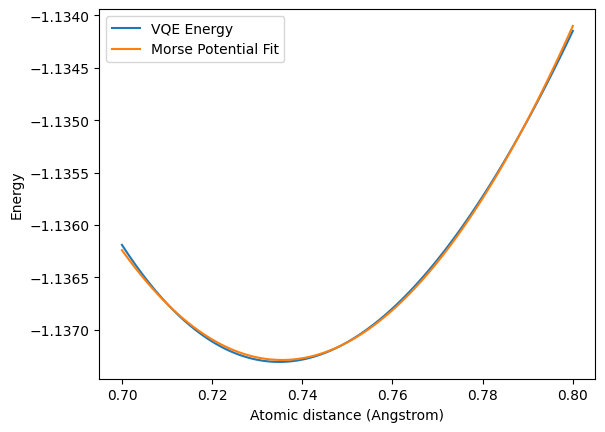

In [6]:
from scipy.optimize import curve_fit
def morse_potential(r, c, m, req):
    return c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))

# poptmp, pcovmp = curve_fit(morse_potential, distances, vqe_mean)
poptmp, pcovmp = curve_fit(morse_potential, distances, vqe_sv_eng)
vqe_pred = [morse_potential(i, poptmp[0], poptmp[1], poptmp[2]) for i in distances]

plt.plot(distances, vqe_sv_eng, label="VQE Energy")
plt.plot(distances, vqe_pred, label="Morse Potential Fit")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [7]:
coords_s256 = np.loadtxt('../data/new data/H2_delta_30_shots_256_coords_2ps_full.txt')
velocity_s256 = np.loadtxt('../data/new data/H2_delta_30_shots_256_velocity_2ps_full.txt')
coords_s512 = np.loadtxt('../data/new data/H2_delta_30_shots_512_coords_2ps_full.txt')
velocity_s512 = np.loadtxt('../data/new data/H2_delta_30_shots_512_velocity_2ps_full.txt')
coords_s1024 = np.loadtxt('../data/new data/H2_delta_30_shots_1024_coords_2ps_full.txt')
velocity_s1024 = np.loadtxt('../data/new data/H2_delta_30_shots_1024_velocity_2ps_full.txt')

In [8]:
femto = 1.0e-15
dt = 0.2*femto
u = 1.67e-27
mass_0 = u
mass_1 = u
mass = np.array([mass_0, mass_1])
times = np.arange(0*femto, 2000.0*femto, dt)

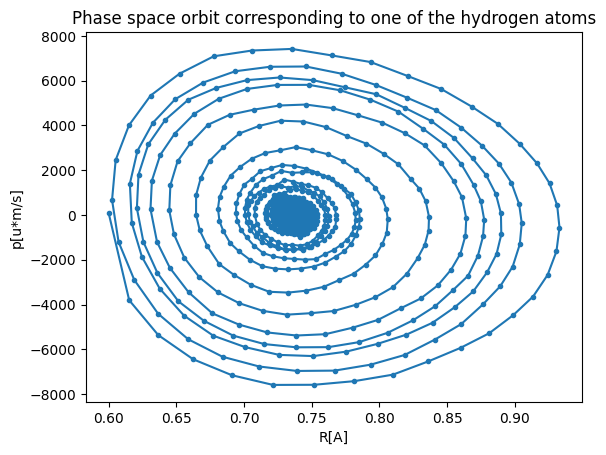

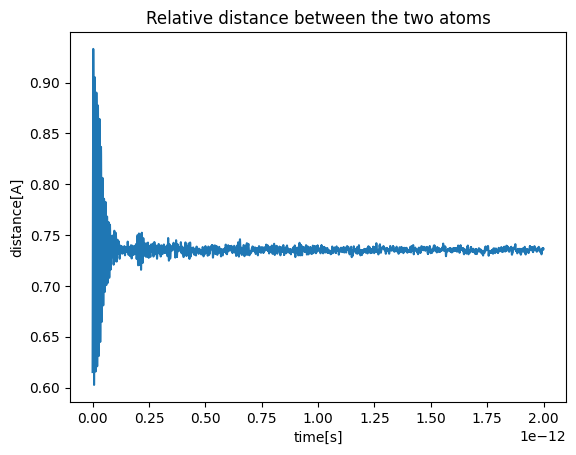

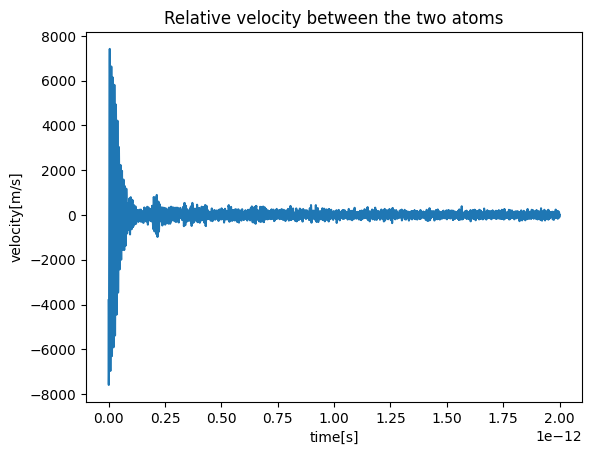

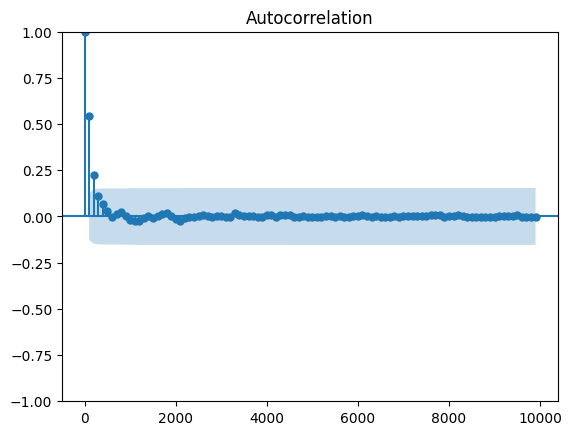

In [9]:
coords_s256 = np.array(coords_s256)
velocity_s256 = np.array(velocity_s256)
momentum_s256 = mass*velocity_s256

dist0 = coords_s256[:,1]-coords_s256[:,0]
v0 = velocity_s256[:,0]
m0 =momentum_s256[:,0]/u

plt.plot(dist0, m0, marker='.')
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*m/s]")
# plt.legend()
plt.show()

plt.plot(times, dist0[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times, v0[1:])
plt.title('Relative velocity between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('velocity[m/s]')
plt.show()

plot_acf(v0, lags=np.arange(0,10000,100), alpha=0.1)
plt.show()

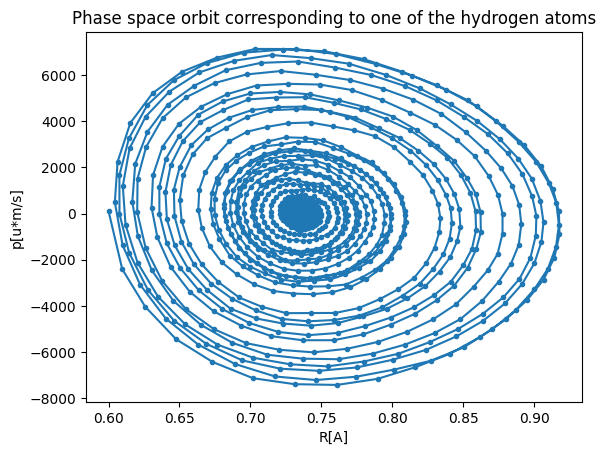

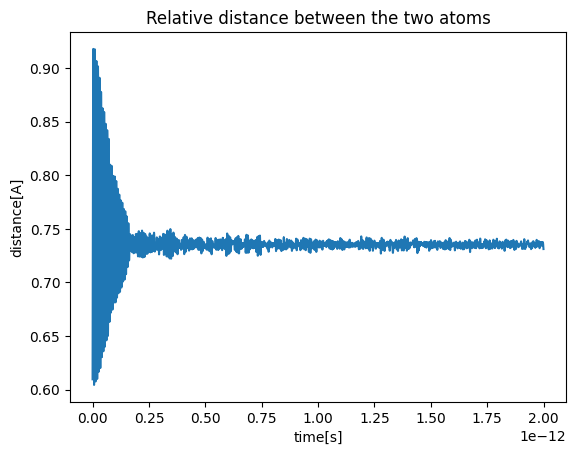

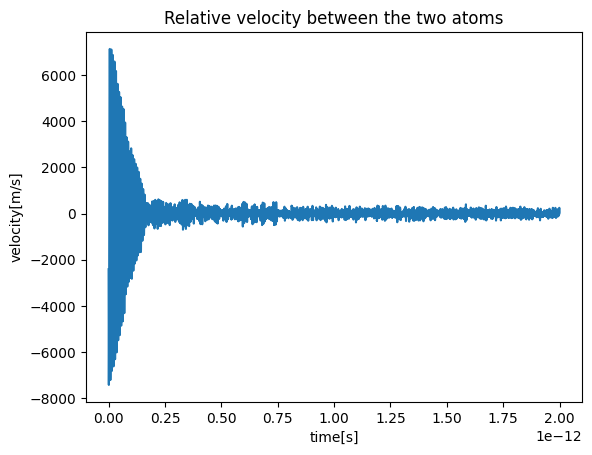

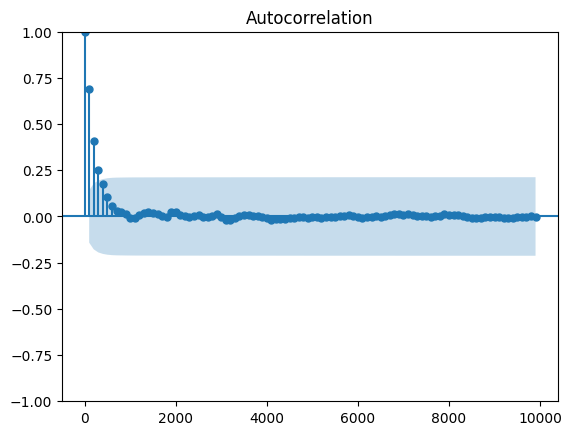

In [10]:
coords_s512 = np.array(coords_s512)
velocity_s512 = np.array(velocity_s512)
momentum_s512 = mass*velocity_s512

dist1 = coords_s512[:,1]-coords_s512[:,0]
v1 = velocity_s512[:,0]
m1 =momentum_s512[:,0]/u

plt.plot(dist1, m1, marker='.')
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*m/s]")
# plt.legend()
plt.show()

plt.plot(times, dist1[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times, v1[1:])
plt.title('Relative velocity between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('velocity[m/s]')
plt.show()

plot_acf(v1, lags=np.arange(0,10000,100), alpha=0.1)
plt.show()

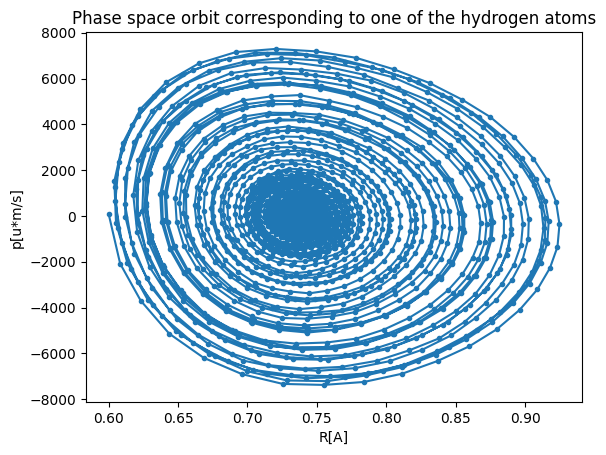

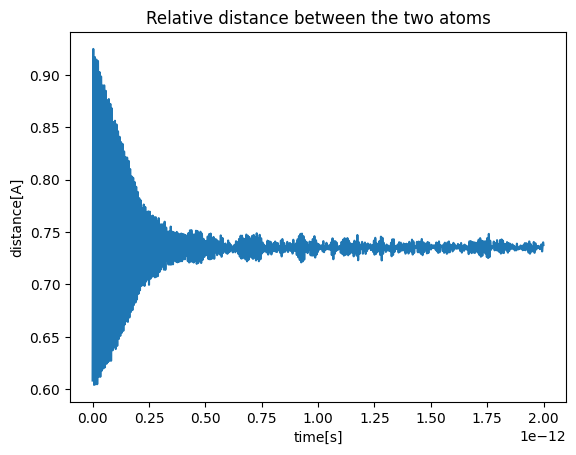

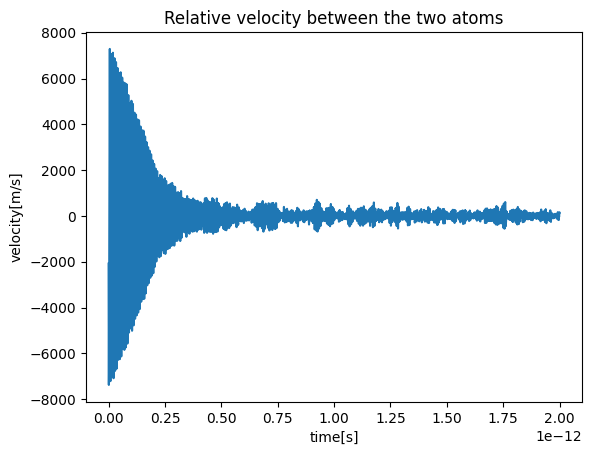

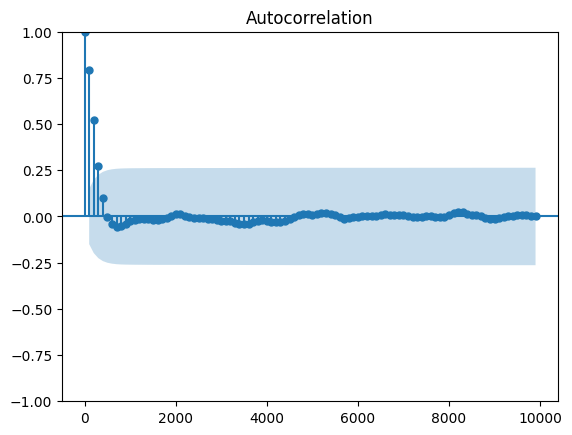

In [11]:
coords_s1024 = np.array(coords_s1024)
velocity_s1024 = np.array(velocity_s1024)
momentum_s1024 = mass*velocity_s1024

dist2 = coords_s1024[:,1]-coords_s1024[:,0]
v2 = velocity_s1024[:,0]
m2 =momentum_s1024[:,0]/u

plt.plot(dist2, m2, marker='.')
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*m/s]")
# plt.legend()
plt.show()

plt.plot(times, dist2[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times, v2[1:])
plt.title('Relative velocity between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('velocity[m/s]')
plt.show()

plot_acf(v2, lags=np.arange(0,10000,100), alpha=0.1)
plt.show()

In [12]:
c = poptmp[0] #Ha
m = poptmp[1] #angst^-1
req = poptmp[2] #angst
# req = np.mean(dist4[5000:])
k_b = 1.38065e-23
Ha = 4.36e-18
kb = k_b/Ha

def func(r, tem, amp):
    return amp*np.exp(-(c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))+c)/(kb*tem))

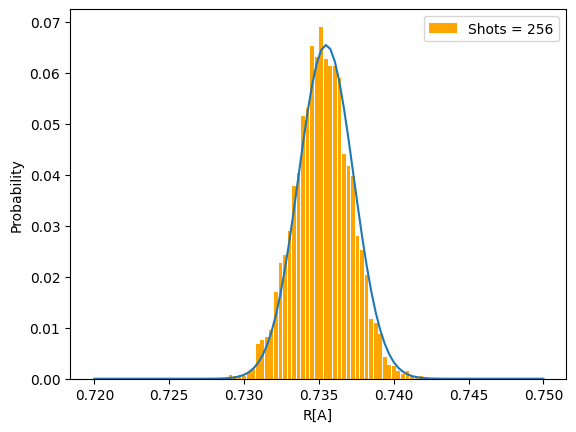

In [27]:
bins = np.linspace(0.72, 0.75,100)
prob = pd.cut(dist0[6000:],bins)
langevin = pd.value_counts(prob, normalize=True).sort_index()
distr_langevin = []
for value in langevin:
    distr_langevin.append(value)

poptstat, pcovstat = curve_fit(func, bins[1:], distr_langevin)
distr_pred = [func(i, poptstat[0], poptstat[1]) for i in bins]

width = 0.00025
plt.bar(np.array(bins[:-1]), np.array(distr_langevin),width=width, color='orange', label="Shots = 256")
plt.plot(np.array(bins), np.array(distr_pred))
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [28]:
n_dof = 1
v_sample = np.array(velocity_s256[6000:])
kin_eng = np.sum(v_sample**2*mass/2, axis=1)
k_T = 2*np.sum(kin_eng)/len(v_sample)/n_dof
T_kin_s256 = k_T/k_b
T_fit_s256 = poptstat[0]

print('Shota = 256: T_kin: %f K, T_fit: %f K.'%(k_T/k_b, poptstat[0]))

Shota = 256: T_kin: 2.024554 K, T_fit: 1.733104 K.


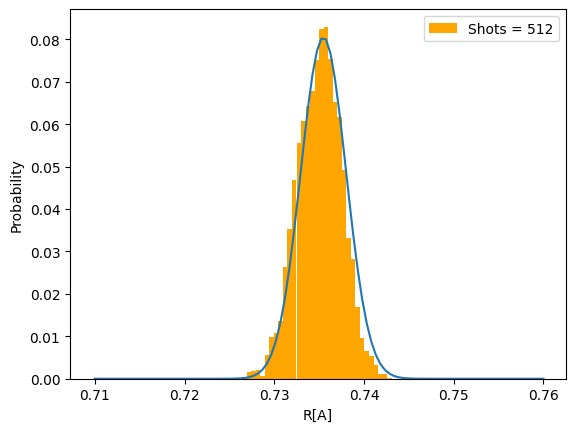

In [24]:
bins = np.linspace(0.71, 0.76,100)
prob = pd.cut(dist1[6000:],bins)
langevin = pd.value_counts(prob, normalize=True).sort_index()
distr_langevin = []
for value in langevin:
    distr_langevin.append(value)

poptstat, pcovstat = curve_fit(func, bins[1:], distr_langevin)
distr_pred = [func(i, poptstat[0], poptstat[1]) for i in bins]

width = 0.0005
plt.bar(np.array(bins[:-1]), np.array(distr_langevin),width=width, color='orange', label="Shots = 512")
plt.plot(np.array(bins), np.array(distr_pred))
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [25]:
n_dof = 1
v_sample = np.array(velocity_s512[6000:])
kin_eng = np.sum(v_sample**2*mass/2, axis=1)
k_T = 2*np.sum(kin_eng)/len(v_sample)/n_dof
T_kin_s512 = k_T/k_b
T_fit_s512 = poptstat[0]

print('Shots = 512: T_kin: %f K, T_fit: %f K.'%(k_T/k_b, poptstat[0]))

Shots = 512: T_kin: 3.354489 K, T_fit: 3.259684 K.


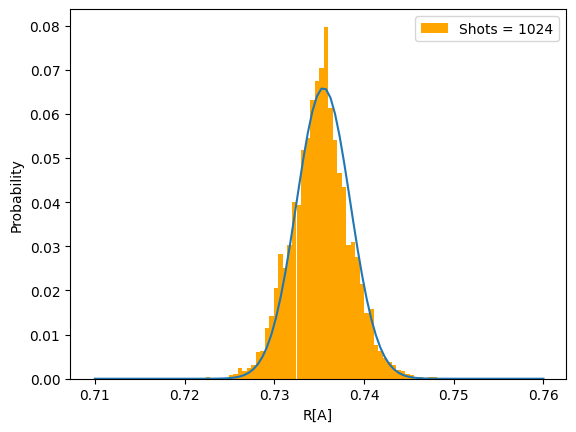

In [43]:
bins = np.linspace(0.71, 0.76,100)
prob = pd.cut(dist2[6000:],bins)
langevin = pd.value_counts(prob, normalize=True).sort_index()
distr_langevin = []
for value in langevin:
    distr_langevin.append(value)

poptstat, pcovstat = curve_fit(func, bins[1:], distr_langevin)
distr_pred = [func(i, poptstat[0], poptstat[1]) for i in bins]

width = 0.0005
plt.bar(np.array(bins[:-1]), np.array(distr_langevin),width=width, color='orange', label="Shots = 1024")
plt.plot(np.array(bins), np.array(distr_pred))
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [41]:
n_dof = 1
v_sample = np.array(velocity_s1024[6000:])
kin_eng = np.sum(v_sample**2*mass/2, axis=1)
k_T = 2*np.sum(kin_eng)/len(v_sample)/n_dof
T_kin_s1024 = k_T/k_b
T_fit_s1024 = poptstat[0]

print('Shots = 50: T_kin: %f K, T_fit: %f K.'%(k_T/k_b, poptstat[0]))

Shots = 50: T_kin: 5.847603 K, T_fit: 4.574378 K.


In [47]:
T_kin = np.array([T_kin_s256, T_kin_s512, T_kin_s1024])
T_fit = np.array([T_fit_s256, T_fit_s512, T_fit_s1024])
shots = np.array([256, 512, 1024])

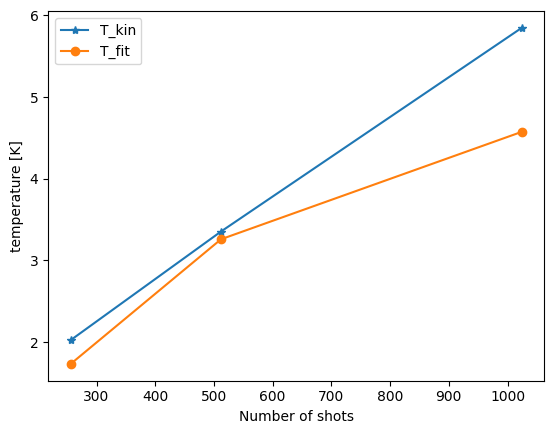

In [48]:
plt.plot(shots, T_kin, marker='*', label='T_kin')
plt.plot(shots, T_fit, marker='o', label='T_fit')
plt.legend()
plt.xlabel('Number of shots')
plt.ylabel('temperature [K]')
plt.show()

In [49]:
T_kin = np.array([4*T_kin_s256, 2*T_kin_s512, T_kin_s1024])
T_fit = np.array([4*T_fit_s256, 2*T_fit_s512, T_fit_s1024])
shots = np.array([256, 512, 1024])

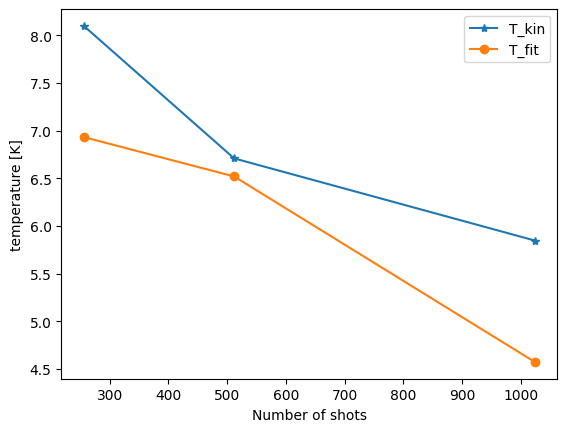

In [50]:
plt.plot(shots, T_kin, marker='*', label='T_kin')
plt.plot(shots, T_fit, marker='o', label='T_fit')
plt.legend()
plt.xlabel('Number of shots')
plt.ylabel('temperature [K]')
plt.show()

It is conter-intuitive that the temperature increases with the increasing of the number of shots. If the statistical noise corresponds to the temperature of the bath, higher number of shots would mean lower temperature. 

The reason is that similar to $\Delta$, the temperature is also scaled by dividing the number of shots, leading to the proportionality between the number of shots and the temperature, which I think should not be the case.